Normalização do modelo BCS não linear

In [446]:
import matplotlib.pyplot as plt
import numpy as np
exec(compile(open('param.py', "rb").read(), 'param.py', 'exec')) #% Roda arquivo com parâmetros do modelo BCS

### Variáveis de entrada
f $\in$ (35,65) Hz <br>
zc $\in$ (0,100)% <br>
pm $\in$ ($2\cdot 10^6$) <br>

### Variáveis de estado
pbh $\in$ ($10^5, 8.5 \cdot 10^6$) <br>
pwh $\in$ ($2 \cdot 10^6, 5.2\cdot10^6$) <br>
q $\in (10^{-2},3\cdot 10^{⁻2})$ <br>



Função para retornar os valores de xc e x0 dado que<br>
$x_{min}<x<x_{max}$ <br>

Nova variável<br>

$xb=\frac{x-x0}{xc}$

Assim <br>

$x=xb\cdot xc+x0$

Fazendo com que a nova variável esteja no intervalo $0<xb<1$ <br>


In [447]:
def Fnorm(xlim):
    # Encontrar o fator de normalização
    # tal que xb=(x-x0)/xc
    # xmin<x<xmax
    # fazendo com que 0<xb<1
    x=(xlim[0],xlim[1]-xlim[0])
    return x
def normalizar(x,xnorm):
    xs=np.zeros((nx,1))
    for i in range(0,nx):
        xs[i]=(x[i]-xnorm[i,0])/xnorm[i,1]
    return xs
def desnormalizar(x,xnorm):
    xs=np.zeros((nx,1))
    for i in range(0,nx):
        xs[i]=x[i]*xnorm[i,1]+xnorm[i,0]
    return xs
def AplicaEscala(var,i):
    aux=var*xnorm[i,1]+xnorm[i,0]
    return aux
def normaliza_u(u,unorm):
    aux=np.zeros_like(u)
    for i in range(0,len(u)):
        aux[i]=(u[i]-unorm[i,0])/unorm[i,1]
    return aux

Definindo os fatores de ajuste de escala a partir dos limites operacionais

In [448]:
# Valores máximos e mínimos para normalização
#Entradas
f_lim=(30,75); zclim=(0,100);pmlim=(1e6,2e6);
pbhlim=(100000,8.5e6); pwhlim=(2e6,5.2e6); qlim=(12/3600,55/3600)
pbhlim=(3e6,8.5e6);pwhlim=(2e6,3.2e6);

In [449]:
pm=2e6; #Simplificando pm fixo
unorm=np.array([Fnorm(f_lim),Fnorm(zclim)])
xnorm= np.array([Fnorm(pbhlim),Fnorm(pwhlim),Fnorm(qlim), unorm[0,:],unorm[1,:]])
#pbh  - pressão na bomba
#pwh - Pressão de fundo do poço,
#q - vazão
#PI índice de produtividade do poço
#PinC  pressão na choke
# Pressão de manifold

Definindo as variáveis simbólicas

In [450]:
# Criando simbolica
from casadi import *
nx = 5; nu = 2;
x = MX.sym("x",nx); # Estados
u = MX.sym("u",nu); # Exogena
dudt_max = MX.sym("dudt_max",2); # Exogena


In [451]:
pbh = AplicaEscala(x[0],0)
pwh = AplicaEscala(x[1],1)
q = AplicaEscala(x[2],2)
fq = AplicaEscala(x[3],3)
zc = AplicaEscala(x[4],4)

In [452]:
# Entradas

fqref = u[0]*unorm[0,1]+unorm[0,0]; zcref = u[1]*unorm[1,1]+unorm[1,0];
pm=2e6;
#pm=(pm-xnorm[0,0])/xnorm[0,1]
pm
#pm = u[2];

2000000.0

Normalizando variáveis dependentes

In [453]:
# Calculo do HEAD e delta de press�o
q0 = q/Cq*(f0/fq);
H0 = -1.2454e6*q0**2 + 7.4959e3*q0 + 9.5970e2;
H = CH*H0*(fq/f0)**2; # Head
Pp = rho*g*H;
# Calculo da press�o de intake
F1 = 0.158*((rho*L1*q**2)/(D1*A1**2))*(mu/(rho*D1*q))**(1/4);
F2 = 0.158*((rho*L2*q**2)/(D2*A2**2))*(mu/(rho*D2*q))**(1/4);

In [454]:
P0 = -2.3599e9*q0**3 -1.8082e7*q0**2 +4.3346e6*q0 + 9.4355e4;
pin = pbh - rho*g*h1 - F1
P = Cp*P0*(fq/f0)**3; # Potencia
I = Inp*P/Pnp;      # Corrente

In [455]:
# Vazao do reservatorio e vazao da choke
qr  = PI*(pr - pbh);

In [456]:
qc  = Cc*(zc/100)*casadi.sign((pwh - pm))*casadi.sqrt(casadi.fabs(pwh - pm));

In [457]:
dpbhdt = b1/V1*(qr - q);
dpwhdt = b2/V2*(q - qc);
dqdt = 1/M*(pbh - pwh - rho*g*hw - F1 - F2 + Pp);

Aplicar escala nas derivadas

In [458]:
dpbhdt=dpbhdt*xnorm[0,1]
dpwhdt=dpwhdt*xnorm[1,1]
dqdt=dqdt*xnorm[2,1]

In [459]:
# Função casadi
dxdt = casadi.vertcat(dpbhdt,dpwhdt,dqdt,0,0)
Eq_Estado = casadi.Function('Eq_Estado',[x,u],[dxdt],
                     ['x','u'],['dxdt'])

In [460]:
y=vertcat(pin,H);
ny = y.size1()
# Equações algébricas
sea_nl = casadi.Function('sea_nl',[x,u],[y,pin,H],\
                 ['x','u'],['y','pin','H']); # Sistema de Eq. Algebricas variaveis de sa�da

In [461]:
BCS={
     'x': x,
     'u': u,
     'y': y,
     'nx': nx,
     'nu': nu,
     'ny': ny,
     'NaoLinear': {'sedo_nl': Eq_Estado(x,u),
                   'sea_nl': sea_nl
                   }
}

In [462]:
#% Func��o objetivo
dxdt_0 = Eq_Estado(BCS['x'], BCS['u']);
J = sum1(dxdt_0**2);

In [463]:
#% Otimizador
opt={
     'ipopt':{
         'print_level':0,
         'acceptable_tol':1e-8,
         'acceptable_obj_change_tol':1e-6,
         'max_iter':50
         },
     'print_time':0,
     }

opt['ipopt']['print_level']=0;# %0,3
opt['print_time']=0;
opt['ipopt']['acceptable_tol']=1e-8;
opt['ipopt']['acceptable_obj_change_tol']=1e-6;
opt['ipopt']['max_iter']=50;

In [464]:
MMQ = {'x':BCS['x'], 'f':J, 'p':BCS['u']}
#nlp={'x':vertcat(BCS['x'],BCS['u']), 'f':J} #variáveis de decisão, função f, g (N/A)
#nlp={'x':BCS['x'], 'f':J}

In [465]:
solver = nlpsol('solver', 'ipopt', MMQ, opt)

In [466]:
# Restrições das variaveis de decis�o
# minimo
args={
      'lbx': np.zeros((nx,1)),
# m�ximo
      'ubx':np.full((nx, 1), np.inf)
      }

# Solu��o do otimizador
sol=solver(x0=BCS['x'], lbx=args['lbx'], ubx=args['ubx'], p=BCS['u']);
yss=sea_nl(sol['x'],BCS['u'])

In [467]:
Estacionario = Function('Estacionario',[BCS['x'],BCS['u']],\
    [sol['x'],yss[0]],\
    ['x0','uss'],['xss','yss']);

BCS['Estacionario'] = Estacionario;

In [468]:
f_ss,zc_ss= (np.array([50, 50]))

In [469]:
uss = np.array([f_ss,zc_ss]); # Entradas do estacionario
uss_n=normaliza_u(uss,unorm)
uss_n

array([0, 0])

In [470]:
#% Calculo do estacionario

#x0 = [0.2,0.5,0.5,0.5,0.5]
x0 = np.array([8311024.82175957,2990109.06207437,0.00995042241351780,50,50]);

In [471]:
x0_n=normalizar(x0,xnorm)
x0_n

array([[0.96564088],
       [0.82509089],
       [0.55398885],
       [0.44444444],
       [0.5       ]])

In [472]:
args['lbx'][3] = uss[0]
args['ubx'][3] = uss[0]  # bounds freq. solver args['lbx'][4] = uss[1]
args['ubx'][4] = uss[1]   # bounds zc solver
#sol=solver('x0',x0, 'lbx', args['lbx'], 'ubx', args['ubx'], 'p', uss);
sol=solver(x0=x0_n,lbx=args['lbx'], ubx=args['ubx'], p=uss_n)
sol['x']

DM([0.965582, 0.825149, 0.554052, 50, 0.500021])

In [473]:
np.array(sol['x'])

array([[ 0.96558155],
       [ 0.82514863],
       [ 0.55405223],
       [50.        ],
       [ 0.50002054]])

In [474]:
xss = desnormalizar(sol['x'],xnorm)

In [475]:
xss

array([[8.31069852e+06],
       [2.99017836e+06],
       [9.95117944e-03],
       [2.28000000e+03],
       [5.00020543e+01]])

In [476]:
x0.reshape(5,1)
sol['x']

DM([0.965582, 0.825149, 0.554052, 50, 0.500021])

In [477]:
pin

MX(@1=(0.00333333+(0.0119444*x[2])), (((3000000+(5500000*x[0]))-1863900)-((0.158*((475000*sq(@1))/6.6775e-06))*pow((0.025/(96.52*@1)),0.25))))

In [478]:
yss=sea_nl(xss_n,uss_n)[0]
yss


DM([6.00014e+06, 592.126])

In [479]:
# Definir variaveis manipuladas e controladas e disturbio externo
mv = [0,1]    #% [f, Zc]
pv = [0,1]  #% [pin, H]  #% [P, I]
#pv = [2,3];  #% [pin, H]
de = 2;      #% [pm]
tg = 2;      #% MV target
#% Parametros
ts = 1;
BCS['u'].shape

(2, 1)

In [480]:
#%Modelo de predição
#% Criando o objeto para predição do modelo
# Iniciando variavel dicionário para a construção da EDO
# sedo = {'x': BCS['x'][0:3], # Estados
#         'p': BCS['u'], #Variáveis exogenas
#         'ode': BCS['NaoLinear']['sedo_nl'] # SEDO (Gerado no bcs_settings)
#         };

sedo = {'x': BCS['x'], # Estados
        'p': BCS['u'], #Variáveis exogenas
        'ode': Eq_Estado(x,u) # SEDO (Gerado no bcs_settings)
        };

#% Criando o objeto p,ra integração da Eq_estado
opt = {'tf':ts,
       't0':0

       };   #% opções do integrador
sedo['ode'].shape
x.shape

(5, 1)

In [481]:
int_odes = integrator('int_odes','cvodes',sedo,opt);

In [482]:
# objeto integrador
res = int_odes(x0=BCS['x'],p=BCS['u']);             #   % solução um passo a frente
npv = len(pv); nmv = len(mv);

In [483]:
# Criando o objeto para solução da equação de medição
Eq_medicao = Function('Eq_medicao',[BCS['x'],BCS['u']],[BCS['y'][pv]],['x','u'],['y']);
# Criacao do objeto para simulacao do BCS Eq de estado + Eq de Medicao
Modelo_Predicao = Function('Modelo_Predicao',[BCS['x'],BCS['u']],[res['xf'],Eq_medicao(res['xf'],BCS['u'])],['xk_1','uk_1'],['xk','yk']);
Modelo_Predicao2 = Function('Modelo_Predicao2',[BCS['x'],BCS['u']],[res['xf']],['xk_1','uk_1'],['xk']);

In [484]:
# Inicializa��o das variaveis
xss=x0_n


xmk = xss;           # Estados
xpk = xss;
uss

array([50, 50])

In [485]:
uk_1=uss[mv];

In [486]:
#xpk=normalizar(xss,xnorm)
xpk=(xss-xnorm[:,0])/xnorm[:,1]
#uk_1 = normaliza_u(uss[mv],unorm)
uk_1=(uss[mv]-unorm[:,0])/unorm[:,1]
# MVS
# Aloca��o de variaveis
Xk = np.zeros((nx,1))


In [487]:
Yk = np.zeros((npv,1))
Uk = np.zeros((nmv,1))
Ymk = Yk
Ys = Yk
Ymin = Yk
Ymax = Yk

### Simulando cenários

In [488]:
tsim = 50;
nsim=int(round(tsim/ts)+1)
xss_n=x0_n
x0_n

array([[0.96564088],
       [0.82509089],
       [0.55398885],
       [0.44444444],
       [0.5       ]])

In [489]:
dxdt[0]



MX((5500000*(3.70005e+08*((2.32e-09*(12600000-(3000000+(5500000*x[0]))))-(0.00333333+(0.0119444*x[2]))))))

In [490]:

uk_1 = np.array([[60], [70]]);
#ypk=desnormalizar_y(np.array(Eq_medicao(xpk,uk_1)),ynorm)
#ypk=np.array(Eq_medicao(xpk,uk_1))
#uk_1n = normaliza_u(uk_1,unorm)
uk_1n=(uk_1.T-unorm[:,0])/unorm[:,1]
uk_1n

array([[0.66666667, 0.7       ]])

In [491]:
#Valores iniciais de simulação

Uk= uss
xpk = Modelo_Predicao2(xss_n,uss_n)
Xk=desnormalizar(xpk,xnorm)
xpk
Yk=sea_nl(xpk,uss_n)[0]
Uk = uk_1

#c)

In [492]:
nsim-1
uk_1n

array([[0.66666667, 0.7       ]])

In [493]:
xi=(np.arange(0,int(nsim*ts)-1,ts));
xi=np.arange(0,10,ts)
xi
uss

array([50, 50])

In [494]:
print("Simulação iniciada")

for k in range(1,10):
#for k in range(1,nsim-1):
    #print('Tempo:',k*ts, 'k=',k)
    xpk = Modelo_Predicao2(xpk,uk_1n)
    print(xpk[0:3])
    #print(desnormalizar(xpk,xnorm))
    Xk = hcat([Xk,desnormalizar(xpk,xnorm)])
    #print(Xk.shape)
    ypk=sea_nl(xpk,uk_1n)[0]
    #y2=sea_nl(desnormalizar(xpk,xnorm),uk_1)
    #y2
    Yk = hcat([Yk,np.array(ypk)]);
    #Yk = hcat([Yk,y2]);
    Uk = hcat([Uk,uk_1])

    #Ymk = hcat([Ymk,ymk]);
    #print("Xk,Yk,Uk,xi shape ="+str(Xk.shape)+" "+str(Yk.shape)+" "+str(Uk.shape)+" "+str(xi.shape))
print("Xk shape ="+str(Xk.shape))
# print("Uk shape ="+str(Uk.shape))
# print("Yk shape ="+str(Uk.shape))
# print("xi shape ="+str(xi.shape))
print("Ok.simulação concluida")
Xk[0,:].shape

Simulação iniciada
[0.965641, 0.825091, 0.553989]
[0.965641, 0.825091, 0.553989]
[0.965641, 0.825091, 0.553989]
[0.965641, 0.825091, 0.553989]
[0.965641, 0.825091, 0.553989]
[0.965641, 0.825091, 0.553989]
[0.965641, 0.825091, 0.553989]
[0.965641, 0.825091, 0.553989]
[0.965641, 0.825091, 0.553989]
Xk shape =(5, 10)
Ok.simulação concluida


(1, 10)

In [495]:
Yk[0,:].T

DM([6.00014e+06, 6.00014e+06, 6.00014e+06, 6.00014e+06, 6.00014e+06, 6.00014e+06, 6.00014e+06, 6.00014e+06, 6.00014e+06, 6.00014e+06])

In [496]:
xi

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

## Produção dos gráficos

<ipython-input-497-3bb343ad2b3d>:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


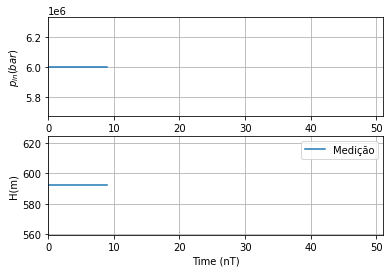

In [497]:
fig1=plt.figure()
label = [r'$p_{in}(bar)$','H(m)','P','I','qc','qr' ];
for iy in range(0,npv):
    ax = fig1.add_subplot(npv,1,iy+1)
    #print(iy)
    if iy == 0: # Pin
        ax.plot(xi,(Yk[iy,:].T), label='Medição')
        #ax.plot(xi,Ymk[iy,:].T/1e5, label='EKF')
        ax.set_ylabel(label[iy])
        ax.set(xlim=(xi[0], nsim*ts))
       # ax.set(ylim=(40,62))
        plt.grid(True)
    else: # H
        ax.plot(xi,Yk[iy,:].T, label='Medição')
        #ax.plot(xi,Ymk[iy,:].T,label='EKF')
        ax.set_ylabel(label[iy])
        ax.set(xlim=(xi[0], nsim*ts))
       # ax.set(ylim=(580, 850))
        plt.grid(True)
#ax.plot(xi,Yk[2,:].T, label='EKF')
ax.legend();
ax.set_xlabel('Time (nT)')
fig1.show()


In [498]:
# Yk[1,:].T.shape
#

In [499]:
xi.shape

(10,)

In [500]:
Uk.shape

(2, 10)

0


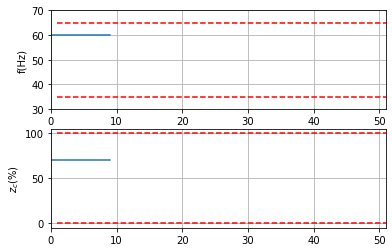

In [501]:
# #% Restrição
umin  = np.array([35, 0]); np.transpose(umin);  # lower bounds of inputs
umax  = np.array([65, 100]); np.transpose(umax); # upper bounds of inputs
dumax = np.array([0.5, dzc_max]); np.transpose(dumax);
fig2=plt.figure()
label = ['f(Hz)',r'$z_c$(%)'];
for iu in range(0,nmv):
    ax2=fig2.add_subplot(nmv,1,iu+1)
    ax2.plot(xi,Uk[iu,:].T, label='Medição')
    ax2.plot([1,nsim],[umin[iu], umin[iu]],'--r')
    ax2.plot([1,nsim],[umax[iu], umax[iu]],'--r', label='Restrição')
    ax2.set_ylabel(label[iu])
    ax2.set(xlim=(xi[0], nsim*ts))
    if iu==0:
        ax2.set(ylim=(30, 70))
        print(iu)
    plt.grid(True)


0


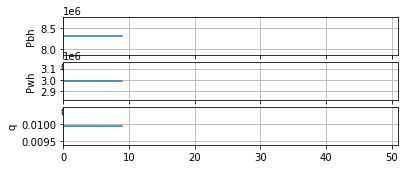

In [502]:
fig3=plt.figure()
label = ['Pbh','Pwh','q'];
for iu in range(0,3):
    ax3=fig3.add_subplot(nx,1,iu+1)
    ax3.plot(xi,Xk[iu,:].T, label='Medição')
    #ax3.plot([1,nsim],[umin[iu], umin[iu]],'--r')
    #ax3.plot([1,nsim],[umax[iu], umax[iu]],'--r', label='Restrição')
    ax3.set_ylabel(label[iu])
    ax3.set(xlim=(xi[0], nsim*ts))
    if iu==0:
        #ax2.set(ylim=(30, 70))
        print(iu)
    plt.grid(True)

In [503]:
# fig1=plt.figure()
# label = [r'$p_{in}(bar)$','H(m)','P','I','qc','qr' ];
# Yk=np.array(Yk).reshape(100,2)
# plt.plot(xi,np.array(Yk[:,0]))
# plt.plot(xi,np.array(Yk[:,1]))

In [504]:
# ax = fig1.add_subplot(2,1,1)
# #ax.set_xlabel('Time (nT)')
# ax.plot(xi,np.array(Yk[:,0]))
# ax = fig1.add_subplot(2,1,2)
# ax.plot(xi,Yk[:,1])
# plt.grid(True)
# fig1.show()

In [505]:
# [Yk[:,0].shape, xi.shape]